# Test 5 and Test 8 (Binary Classification on Lenses)

* Framework: Pytorch with fastai
* Framework: Pytorch + fastai
    * fastai performs some high level abstractions and helps us concentrate on the model building process and encouarages quick iteration
    * Useful in scenarios where we want to try out multiple ideas, architeactures quickly without worrying about efficient training loop optimization
* Image model: From tim models: 
    * Swin Transformers is a type of convolutional neural network architecture for image classification that replaces the traditional convolutional layers with self-attention mechanisms inspired by the transformer architecture. The Swin Transformer architecture is designed to process images at different scales and resolutions, which allows it to achieve state-of-the-art accuracy while requiring fewer computational resources than previous models.
    * Swin-S3-Tiny-224 is a specific version of the Swin Transformer architecture that is optimized for mobile and embedded devices. It has a smaller number of layers and parameters than larger Swin Transformer models, which makes it faster and more efficient. The timm library provides pre-trained weights for the Swin-S3-Tiny-224 model, which can be fine-tuned on other image classification tasks.
    * Swin Transformer is a type of Vision Transformer (ViT) architecture that replaces the traditional convolutional layers with self-attention mechanisms inspired by the transformer architecture. ViT was originally introduced for image classification in the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al., and Swin Transformer is an extension of this idea that is designed to process images at different scales and resolutions.
* Augmentations: 
    * Horizontal flip
    * Vertical flip
    * Rotate 90
    * All of them have 50% prob
    * Helps combat overfitiing and effectively increases dataset size; thus better generalisatoin
* AUC Score: 1

## Import required libraries

In [1]:
# Import required libraries
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from fastai.callback.wandb import *
from fastai.vision.all import *
import glob
import timm
import uuid
import tqdm
from PIL import Image
import cv2

## Setup Wandb to log the experiment and models

In [2]:
wandb.login()

wandb: Currently logged in as: lawjarp. Use `wandb login --relogin` to force relogin


True

## Setup Configuration

* We will be using a image size of 224,224
* Swin transformers are seen to perform very well in image classification tasks and have been used regualry for the same purpose. (Competitions in Kaggle)

In [3]:
config = {
    "image_size": (224,224),
    "batch_size": 16,
    "base_model": "swin_s3_tiny_224"
}

## Get Data files

In [4]:
# Get data
# Split data into train and test
categories = {
    "sub": 0,
    "no_sub": 1,
}

dataset_path = "/notebooks/gsoc-prep-23/ml4sci/data/lenses/"

# Get file paths as a list
all_files = glob.glob(dataset_path + "*/*")
all_labels = [x.split('/')[-2] for x in all_files]

print("Got files", len(all_files))

Got files 10000


In [5]:
print(all_files[0], all_labels[0])
print(all_files[-1], all_labels[-1])

/notebooks/gsoc-prep-23/ml4sci/data/lenses/sub/image_135943293325140772155714425003138958756.jpg sub
/notebooks/gsoc-prep-23/ml4sci/data/lenses/no_sub/image_30922263493132764425775209234469258991.jpg no_sub


(150, 150)


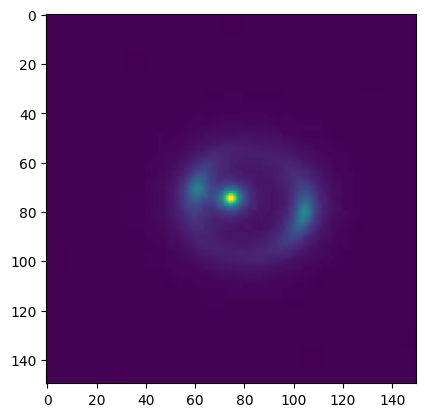

In [6]:
test = Image.open(all_files[0])
print(test.size)
plt.imshow(test)

## Define Dataset objects, augment and split data

In [7]:
# Dataset object
# Use albumentations for data augmentation
class SubstructureBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_files, transform=None):
        self.data_files = data_files
        self.transform = transform
    def __len__(self):
        return len(self.data_files)
    def __getitem__(self, idx):
        # Open as one channel
        image = np.array((Image.open(self.data_files[idx])).convert('L'))
        # Get label from path
        label = categories[self.data_files[idx].split("/")[-2]]
        # Apply transformations
        if self.transform:
            image = self.transform(image=image)["image"]
        # Convert to tensor
        label = torch.tensor([label], dtype=torch.float32)
        # Min max normalise
        image = (image - image.min() ) / ( image.max() - image.min())
        return image.to(torch.float32),label

In [8]:
# Split into 90-10
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42, stratify=all_labels)

In [9]:
# Define the augmentations
# Handles overfitting and facilitates better training
train_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.pytorch.transforms.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.pytorch.transforms.ToTensorV2()
])

train_dataset = SubstructureBinaryDataset(train_files, transform=train_transform)
val_dataset = SubstructureBinaryDataset(val_files, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

In [10]:
# Sanity check
b = next(iter(train_dataloader))
print(b[0][0].shape)
print(b[1][0].shape)

torch.Size([1, 224, 224])
torch.Size([1])


## Define Model
* Use a custom head
    * Add a few more layers with batchnorma and dropout

In [11]:
# Define pytorch model
# Use timm for pretrained models
# Define the pytorch model
# Create a model using timm
def create_model(model_name,num_classes=1):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, in_chans=1)
    # Check if classifier is parameter of the model
    if hasattr(model, 'head'):
        model.head = torch.nn.Sequential(
            torch.nn.Linear(model.head.in_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes),
            torch.nn.Sigmoid(),
        )
    return model

## Define Fastai Dataloaders

In [12]:
dls = DataLoaders(train_dataloader, val_dataloader)

## Setup WandB and logging 
* Use Modelcheckpoint to save best model; minimum `val_loss`
* Log the model weights to wandb

In [13]:
run_id = "ml4sci:t5:"+config['base_model']+":"+str(uuid.uuid4().hex)[:3]

# start logging a wandb run
wandb.init(
    project="gsoc-ml4sci",
    entity="lawjarp",
    name=run_id,
    group=config['base_model'],
)

## Get model

In [14]:
model = create_model(config['base_model'], 1)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Define Learner
* Add callbacks to save best model

In [15]:
learn = Learner(
    dls,
    model,
    loss_func=BCELossFlat(),
    cbs=[
        SaveModelCallback(monitor='valid_loss',  fname=run_id),
        WandbCallback(log_model=True, model_name=config['base_model']),
    ])

## Get optimum LR

The lr_find method is a powerful tool for determining the optimal learning rate for training a neural network, as it can save time and improve the overall performance of the model. By using the lr_find method, you can avoid the time-consuming trial and error process of trying different learning rates manually, and instead, let the algorithm find the optimal learning rate for you.

In fastai, lr_find is a method that can be used to determine an optimal learning rate for training a neural network. The lr_find method works by gradually increasing the learning rate during training and recording the loss at each step. The learning rate is increased exponentially in a predetermined range, which is specified by the user.

During this process, the loss is plotted against the learning rate on a logarithmic scale. The plot is then analyzed to determine the optimal learning rate to use for training. The optimal learning rate is typically the learning rate at which the loss starts to decrease rapidly or levels off.

SuggestedLRs(valley=6.30957365501672e-05)

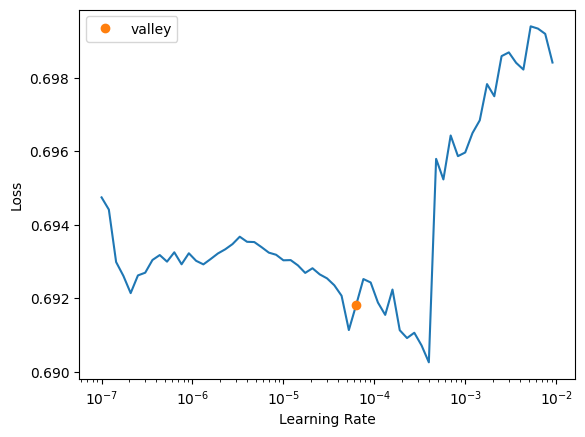

In [16]:
learn.lr_find()

## Fit the model
* Using one cycle polilcy for training

The One Cycle Policy involves training a neural network using a learning rate that first increases linearly to a maximum value, and then decreases back to a minimum value, all within one cycle of training. Specifically, the learning rate is first increased from a low value to a maximum value for a certain portion of the training, and then decreased from the maximum value back to the initial low value for the remaining portion of the training. Additionally, the momentum is typically increased during the first half of the cycle, and then decreased during the second half.

The One Cycle Policy has been shown to be an effective learning rate scheduling technique, as it allows for faster training convergence, improved accuracy, and reduced generalization error. It works by allowing the model to quickly explore a wide range of learning rates, while also regularizing the model and preventing overfitting.

In [17]:
learn.fit_one_cycle(10, 6.30957365501672e-05)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'SubstructureBinaryDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,0.626579,0.501026,01:10
1,0.339021,0.562200,01:11
2,0.261559,0.203501,01:11
3,0.231149,0.141738,01:11
4,0.137078,0.050398,01:11
5,0.083287,0.032783,01:11
6,0.079406,0.027223,01:10
7,0.042851,0.016033,01:10
8,0.023671,0.010962,01:10
9,0.020727,0.010366,01:10


Better model found at epoch 0 with valid_loss value: 0.501026451587677.
Better model found at epoch 2 with valid_loss value: 0.20350100100040436.
Better model found at epoch 3 with valid_loss value: 0.14173826575279236.
Better model found at epoch 4 with valid_loss value: 0.05039774999022484.
Better model found at epoch 5 with valid_loss value: 0.032783087342977524.
Better model found at epoch 6 with valid_loss value: 0.02722257934510708.
Better model found at epoch 7 with valid_loss value: 0.01603291556239128.
Better model found at epoch 8 with valid_loss value: 0.010962199419736862.
Better model found at epoch 9 with valid_loss value: 0.010365673340857029.


## Get AUC scores

In [19]:
model_weights = torch.load("./models/"+config['base_model']+".pth")
# Init model
model = create_model(config['base_model'], 1)
# model_weights = checkpoint["state_dict"]
# Load weights into model
model.load_state_dict(model_weights)

<All keys matched successfully>

In [22]:
model.to('cuda')
model.eval()
val_preds = []
val_targets = []
with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        x,y = batch
        x = x.to('cuda')
        outputs = model(x)
        val_preds.extend(outputs.cpu().numpy())
        val_targets.extend(y.cpu().numpy())

100%|██████████| 63/63 [00:03<00:00, 20.09it/s]


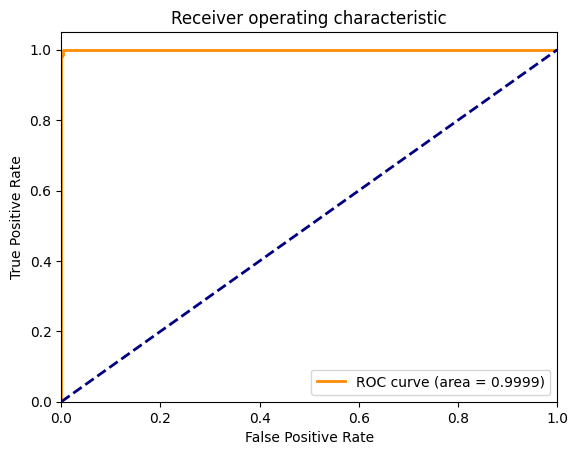

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have `val_targets`, `val_preds`, and `val_auc` variables for binary classification
fpr, tpr, thresholds = roc_curve(val_targets, val_preds)
roc_auc = roc_auc_score(val_targets, val_preds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
print("AUC scores", roc_auc)

AUC scores 0.999928


In [25]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,████▇▄▄▄▇█▆▄▃▂▂▄▃▃▃▁▃▄▁▁▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████▇▅▅▄▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
train_samples_per_sec,██▇▆▆▆▆▆▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▄▅▃▅▂▅▁▅▃▃▅▅▅▅▄▅▅
valid_loss,▇█▃▃▂▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,10
